<a href="https://colab.research.google.com/github/knattarina/wildfire_challenge/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

TEST_DATA_SIZE = 90

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

Mounted at /content/drive


In [ ]:
##### IMPORT DATA #####

forecasts_df = pd.read_csv('Cleansed_Forecasts.csv')
df = pd.read_csv('Cleansed_Data.csv')

forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'])
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
columns = ['Date', 'Region', 'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power',	'Mean_confidence']

df_region = df[df['Region'] == 'QL'].copy()
df_region.drop(columns = ['Date', 'Region'], inplace = True)
df_region

,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,RelativeHumidity_Variance,SoilWaterContent_Max,SoilWaterContent_Mean,SoilWaterContent_Min,SoilWaterContent_Variance,SolarRadiation_Max,SolarRadiation_Mean,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance,Month,Year,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea,count()[unit: km^2]
11563,38.831579,322.197368,45.757895,83.315789,74.452164,1.453053,0.0,35.641257,95.898270,47.959364,14.443199,403.134377,0.472416,0.185641,0.000000e+00,0.012679,31.982830,27.056979,6.033827,29.500832,37.047943,28.842866,20.951620,13.792599,7.675632,3.483753,1.106028,0.883048,1,2005,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3,1.730605e+06
11564,64.464286,315.991071,58.492857,86.785714,87.775497,1.544607,0.0,36.370861,95.837463,48.593844,19.908998,418.233850,0.477548,0.177612,0.000000e+00,0.011915,31.729107,26.276294,4.372402,27.100196,35.675449,29.416449,21.426340,10.519515,7.094274,3.145954,0.900613,0.951232,1,2005,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3,1.730605e+06
11565,47.386585,333.092683,69.860976,88.634146,55.630913,3.307646,0.0,55.229505,97.793060,54.993082,23.762615,321.556066,0.474464,0.180547,0.000000e+00,0.009789,31.707254,25.261123,3.596726,20.015944,35.998322,29.837556,23.180372,7.215216,7.156260,3.376279,0.678431,1.197812,1,2005,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3,1.730605e+06
11566,30.100000,315.216667,31.395833,89.458333,73.792183,7.174250,0.0,115.028624,96.219215,68.853479,32.426708,158.471173,0.490053,0.221695,4.041164e-07,0.010189,30.015615,19.133625,5.608485,29.837734,31.970034,27.344346,23.165539,3.151807,9.109385,3.087130,0.907614,1.030539,1,2005,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3,1.730605e+06
11567,4.000000,326.412500,58.150000,85.750000,94.064049,11.410645,0.0,246.249524,92.610512,69.268049,20.808424,354.098274,0.511396,0.259284,8.472707e-07,0.014463,32.637787,17.328773,5.111666,43.214968,31.534004,26.426117,18.141447,7.098645,8.062080,3.159938,1.122996,1.365404,1,2005,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3,1.730605e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17341,78.670769,322.305385,41.896923,87.800000,44.983952,1.769690,0.0,26.448536,93.493095,41.505174,14.769243,516.251343,0.475812,0.172762,2.327530e-07,0.009995,30.676556,25.084729,8.896174,24.536368,31.110630,23.244205,15.386983,11.972870,6.870927,2.858941,0.507665,0.656063,10,2020,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3,1.730605e+06
17342,119.608649,320.891892,209.929730,87.351351,53.570747,1.598588,0.0,27.491621,88.812210,34.364756,9.392016,519.339361,0.473505,0.165709,0.000000e+00,0.010422,31.352774,28.033695,16.663504,10.204895,31.255157,23.345542,15.299400,9.130294,5.969506,3.272644,0.894660,0.684547,10,2020,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3,1.730605e+06
17343,249.090625,327.207552,56.365104,88.010417,10.742613,0.076241,0.0,0.283345,85.109924,30.359122,9.449774,313.025023,0.432511,0.155046,0.000000e+00,0.008578,31.411791,29.804340,21.400858,2.610120,30.942204,24.280550,15.277708,6.382612,7.196375,2.929369,0.777750,0.845396,10,2020,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1

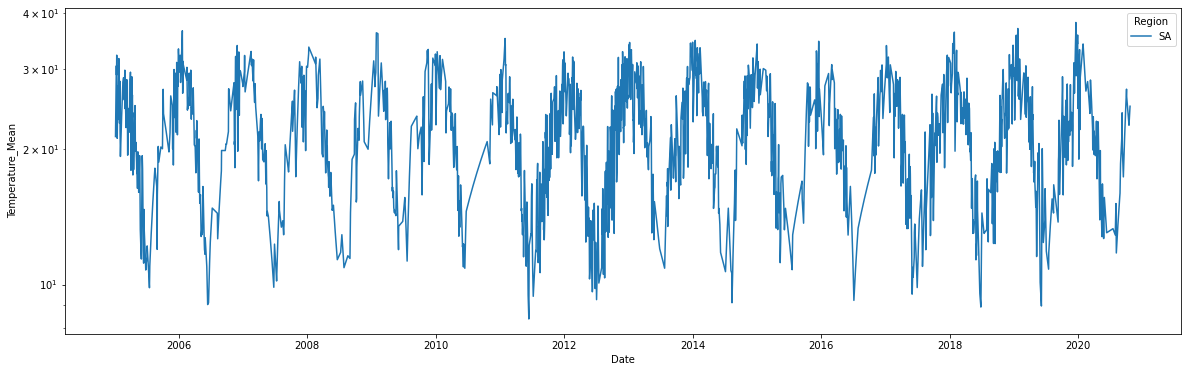

In [ ]:
import folium
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt 
%matplotlib inline

from shapely.geometry import mapping
from shapely.geometry import Polygon
from folium.plugins import TimeSliderChoropleth

df_region = df[df['Region'] == 'SA'].copy()
plt.figure(figsize=(20, 6))
g = sns.lineplot(x="Date", y="Temperature_Mean",hue='Region', data=df_region)
g.set_yscale("log")

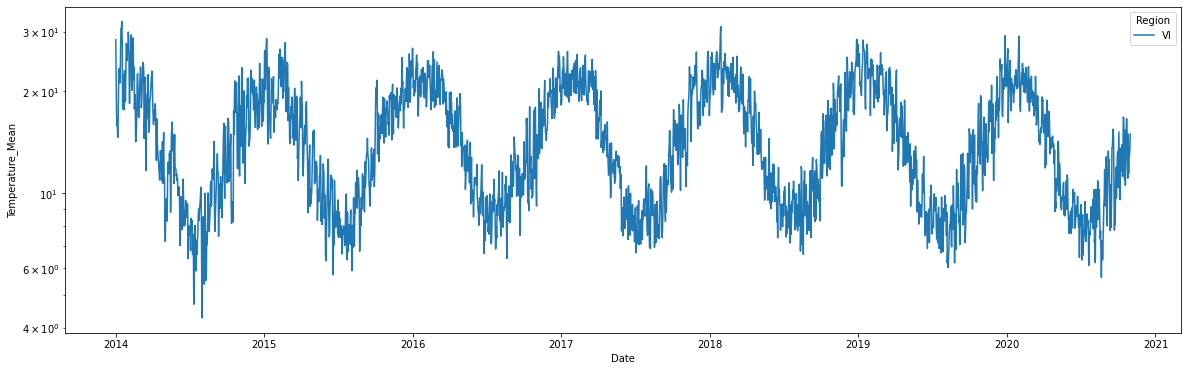

In [ ]:
df_region = forecasts_df[forecasts_df['Region'] == 'VI'].copy()
plt.figure(figsize=(20, 6))
g = sns.lineplot(x="Date", y="Temperature_Mean",hue='Region', data=df_region)
g.set_yscale("log")

In [ ]:
forecasts_df.isna().sum()

Date                         0
Region                       0
Precipitation_Max            0
Precipitation_Mean           0
Precipitation_Min            0
Precipitation_Variance       0
RelativeHumidity_Max         0
RelativeHumidity_Mean        0
RelativeHumidity_Min         0
RelativeHumidity_Variance    0
SolarRadiation_Max           0
SolarRadiation_Mean          0
SolarRadiation_Min           0
SolarRadiation_Variance      0
Temperature_Max              0
Temperature_Mean             0
Temperature_Min              0
Temperature_Variance         0
WindSpeed_Max                0
WindSpeed_Mean               0
WindSpeed_Min                0
WindSpeed_Variance           0
Month                        0
Year                         0
dtype: int64

In [ ]:
target_names = ['Estimated_fire_area']

shift_days = 30
shift_steps = 1 * shift_days

In [ ]:
df_targets = df_region[target_names].shift(-shift_steps)

In [ ]:
x_data = df_region.values[0:-shift_steps]
y_data = df_targets.values[:-shift_steps]

train_split = 0.9
num_data = len(x_data)
num_train = int(train_split * num_data)
num_test = num_data - num_train

x_train = x_data[0:num_train]
x_test = x_data[num_train:]

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

num_y_signals = y_data.shape[1]
num_x_signals = x_data.shape[1]

In [ ]:
x_data

array([[3.88315790e+01, 3.22197368e+02, 4.57578947e+01, ...,
        1.10000000e+01, 3.00000000e-01, 1.73060504e+06],
       [6.44642857e+01, 3.15991071e+02, 5.84928571e+01, ...,
        1.10000000e+01, 3.00000000e-01, 1.73060504e+06],
       [4.73865854e+01, 3.33092683e+02, 6.98609756e+01, ...,
        1.10000000e+01, 3.00000000e-01, 1.73060504e+06],
       ...,
       [1.42245161e+02, 3.18097312e+02, 6.36892473e+01, ...,
        1.10000000e+01, 3.00000000e-01, 1.73060504e+06],
       [1.23744706e+02, 3.24819853e+02, 6.90750000e+01, ...,
        1.10000000e+01, 3.00000000e-01, 1.73060504e+06],
       [1.42443750e+02, 3.18818229e+02, 4.89489583e+01, ...,
        1.10000000e+01, 3.00000000e-01, 1.73060504e+06]])

In [ ]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [ ]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(5177, 45)
(5177, 1)


In [ ]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [ ]:
batch_size = 256
sequence_length = 7 * 8

generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [ ]:
x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(256, 56, 45)
(256, 56, 1)


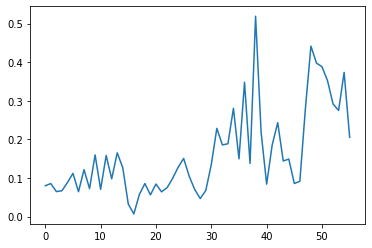

In [ ]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

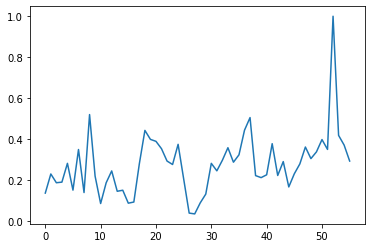

In [ ]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [ ]:
validation_data = (np.expand_dims(x_test_scaled, axis=0), np.expand_dims(y_test_scaled, axis=0))

In [ ]:
model = Sequential()
model.add(GRU(units=512, return_sequences=True, input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

In [ ]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals, activation='linear', kernel_initializer=init))

In [ ]:
warmup_steps = 50

def loss_mse_warmup(y_true, y_pred):
    """ Calculate the Mean Squared Error between y_true and y_pred, but ignore the beginning "warmup" part of the sequences.
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [ ]:
optimizer = RMSprop(lr=1e-3)

In [ ]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         858624    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 859,137
Trainable params: 859,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./logs/', histogram_freq=0, write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-4, patience=0, verbose=1)

callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard, callback_reduce_lr]

In [ ]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=200,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
200/200 [==============================] - 15s 38ms/step - loss: 0.0105 - val_loss: 0.0013

Epoch 00001: val_loss improved from inf to 0.00132, saving model to checkpoint.keras
Epoch 2/20
200/200 [==============================] - 6s 32ms/step - loss: 0.0029 - val_loss: 0.0015

Epoch 00002: val_loss did not improve from 0.00132

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/20
200/200 [==============================] - 6s 32ms/step - loss: 0.0018 - val_loss: 0.0017

Epoch 00003: val_loss did not improve from 0.00132

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 4/20
200/200 [==============================] - 6s 32ms/step - loss: 0.0016 - val_loss: 0.0017

Epoch 00004: val_loss did not improve from 0.00132
Epoch 5/20
200/200 [==============================] - 6s 32ms/step - loss: 0.0015 - val_loss: 0.0018

Epoch 00005: val_loss did not improve from 0.00132
Epoch 6/20
200/200 [==============================] 

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0), y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 25ms/step - loss: 0.0013


In [ ]:
print("loss (test-set):", result)

loss (test-set): 0.0013163065304979682


In [ ]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

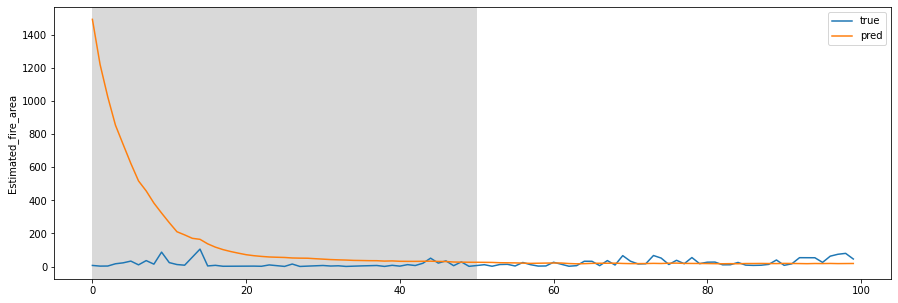

In [ ]:
plot_comparison(start_idx=3000, length=100, train=True)